In [69]:
import numpy as np
import cv2
import time
import imutils
from imutils import contours as imutilscontours
import serial

# arduinoData = serial.Serial('com12', 115200)
def control_motor(direction, time): #direction 0 or 1, time im miliseconds
    d = int(direction+1)
    if time < 100: 
        z = str(d) + '00' + str(time)
    else:
        z = str(d) + '0' + str(time)
    
    f = bytes(z, encoding='utf-8')
    print(z)
    arduinoData.write(f)

# test with dot image
image = cv2.imread("dots.jpg")

# config the color range
lower_red_bgr=np.array([0, 0, 200])
upper_red_bgr=np.array([40, 40, 255])

lower_red_hsv_a = np.array([170,125,150])
upper_red_hsv_a = np.array([180,255,255])

lower_red_hsv_b = np.array([0,100,190])
upper_red_hsv_b = np.array([10,255,255])


# start the capture
cap = cv2.VideoCapture('http://192.168.178.12:8080/video')
time.sleep(1.0)
if not cap.isOpened():
    print("Cam open failed")
else:
#     cap.set(cv2.CAP_PROP_FRAME_WIDTH,1920); # 1080p
#     cap.set(cv2.CAP_PROP_FRAME_HEIGHT,1080); # 1080p
    
#     cap.set(cv2.CAP_PROP_FRAME_WIDTH,1280); # 720p
#     cap.set(cv2.CAP_PROP_FRAME_HEIGHT,720); # 720p
    
    # Check the resolution
    frame_size = (int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)),
                  int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)))
    print('res'),print(frame_size)
    
    ret, frame = cap.read()
    cv2.imshow('Preview',frame)

    # print(cap.get(cv2.CAP_PROP_FPS))
    cap.set(cv2.CAP_PROP_FPS, 30)
    print(cap.get(cv2.CAP_PROP_FPS))

# img = np.array(frame)
# for i in range(img.shape[0]):
#     for j in range(img.shape[1]):
#         if(i < img.shape[0]/2):
#             img[i,j] = lower_red_bgr
#         else:
#             img[i,j] = upper_red_bgr
# # img = cv2.cvtColor(img,cv2.COLOR_HSV2BGR)
# cv2.imshow('test',img)

# main loop
# control_motor(0, 150)
i=1
lock = False
old = time.time()
t_old = time.time()
gc = 0
acc_c = 0
while(cap.isOpened()):
    gc += 1
    t_new = time.time()
    #every 1 second
    if (t_new-t_old) > 1:
        acc = 100 * acc_c / gc
        acc_c = 0
        gc = 0
        acc_text = "Acc : %0.1f" % acc
        t_old = t_new
    
    # Capture frame-by-frame
    ret, frame = cap.read()

    # Our operations on the frame come here
    blurred = cv2.GaussianBlur(frame, (11, 11), 0)
    hsv=cv2.cvtColor(blurred,cv2.COLOR_BGR2HSV)
    mask_bgr=cv2.inRange(hsv,lower_red_bgr,upper_red_bgr)
    mask_hsv_a = cv2.inRange(hsv,lower_red_hsv_a,upper_red_hsv_a)
    mask_hsv_b = cv2.inRange(hsv,lower_red_hsv_b,upper_red_hsv_b)
    mask = mask_bgr + mask_hsv_a + mask_hsv_b
    mask = mask_hsv_a + mask_hsv_b
    #remove noise
    mask = cv2.erode(mask, None, iterations=2)
    mask = cv2.dilate(mask, None, iterations=2)
    
    # find the objects
    cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    contours, hierarchy = cnts
    cnts = imutils.grab_contours(cnts)
#     cnts = sorted(cnts, key=lambda x: cv2.contourArea(x))
#     cnts = sorted(cnts, key=cv2.contourArea)
    if len(cnts) != 0:
        cnts, a = imutilscontours.sort_contours(cnts)
        acc_c += 1
    
    # find the 4 centers
    center = list()
    n = min(len(cnts),4)
    for i in range(n):
        # find the 4 largest contours in the mask, then use
        # it to compute the centroid
        c = cnts[i]
        M = cv2.moments(c)
        center.append((int(M["m10"] / M["m00"]), int(M["m01"] / M["m00"])))
        # only proceed if the radius meets a minimum size
        # draw the Contours and centroid on the frame
        cv2.drawContours(frame, contours, i,  (255, 0, 0), 1)
        cv2.circle(frame, center[i], 1, (0, 255, 0), -1)
    
    # Trigonometry comes here
    # TODO
    # calculate the distances and the angle
    print(center)
    if n == 4:
        
        fp1 = center[0]
        fp2 = center[3]
        if center[1][1] > center[2][1]:
            cart = center[1]
            ptip = center[2]
        else:
            cart = center[2]
            ptip = center[1]
        cv2.putText(frame, 'fp1', fp1, cv2.FONT_HERSHEY_DUPLEX, 0.5, (0, 255, 0))
        cv2.putText(frame, 'fp2', fp2, cv2.FONT_HERSHEY_DUPLEX, 0.5, (0, 255, 0))
        cv2.putText(frame, 'cart', cart, cv2.FONT_HERSHEY_DUPLEX, 0.5, (0, 255, 0))
        cv2.putText(frame, 'tip', ptip, cv2.FONT_HERSHEY_DUPLEX, 0.5, (0, 255, 0))
        
        #calculate distances
        fd_pixels = np.sqrt((fp1[0]-fp2[0])**2 + (fp1[1]-fp2[1])**2)
        l_pixels = np.sqrt((cart[0]-ptip[0])**2 + (cart[1]-ptip[1])**2)
        
        cv2.line(frame, fp1, fp2, (0,255,0), 1)
        
        cv2.line(frame, cart, ptip, (0,255,0), 1)
#         cv2.putText(frame, str(l_pixels), (ptip+cart)/2, cv2.FONT_HERSHEY_DUPLEX, 0.5, (0, 255, 0))
        
        # Estimate the base angle
        base_delta_x = fp1[0]-fp2[0]
        base_delta_y = fp1[1]-fp2[1]
        base_angle = np.arctan2(base_delta_x,base_delta_y)
        
        
        #Estimate of the angle
        delta_x = cart[0]-ptip[0]
        delta_y = cart[1]-ptip[1]
        theta = np.arctan2(delta_x,delta_y)
        theta_text = "Theta: %0.1f" %(theta*180/np.pi)
        cv2.putText(frame, theta_text , (100, 10), cv2.FONT_HERSHEY_DUPLEX, 0.5, (0, 255, 0))
    # Communication comes here
    # TODO
    # send the information to the main script
    # https://medium.com/python-pandemonium/python-socket-communication-e10b39225a4c
    
    
    # Display the number of the center
#     for i in range(len(center)):
#         cv2.putText(frame, str(i), center[i], cv2.FONT_HERSHEY_DUPLEX, 0.5, (0, 255, 0))
    # Display the frames per second
    now = time.time()
    fps = 1/(now - old)
    fps_text = "FPS : %0.0f" % fps
    old = now
    cv2.putText(frame, fps_text, (0, 10), cv2.FONT_HERSHEY_DUPLEX, 0.5, (0, 255, 0))
    cv2.putText(frame, acc_text , (250, 10), cv2.FONT_HERSHEY_DUPLEX, 0.5, (0, 255, 0))
    # Display the resulting frame
    cv2.imshow('Preview',frame)
    
    # exit on ESC
    key = cv2.waitKey(1)
    if key == 27:
        break

# When everything done, release the capture
cap.release()
cv2.destroyAllWindows()
# arduinoData.close()

Cam open failed


NameError: name 'arduinoData' is not defined

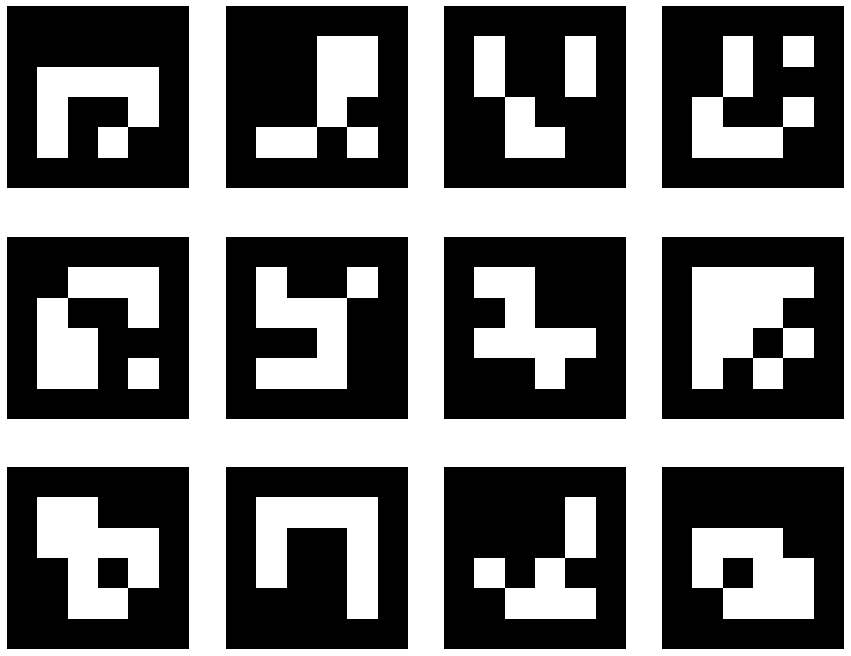

In [54]:
import numpy as np
import cv2, PIL
from cv2 import aruco
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
arucodict = aruco.DICT_4X4_50
aruco_dict = aruco.Dictionary_get(arucodict)
fig = plt.figure(figsize = (15,12))
nx = 4
ny = 3
for i in range(1, nx*ny+1):
    ax = fig.add_subplot(ny,nx, i)
    img = aruco.drawMarker(aruco_dict,i, 700)
    plt.imshow(img, cmap = mpl.cm.gray, interpolation = "nearest")
    ax.axis("off")

plt.savefig("data/markers.jpg")
plt.show()

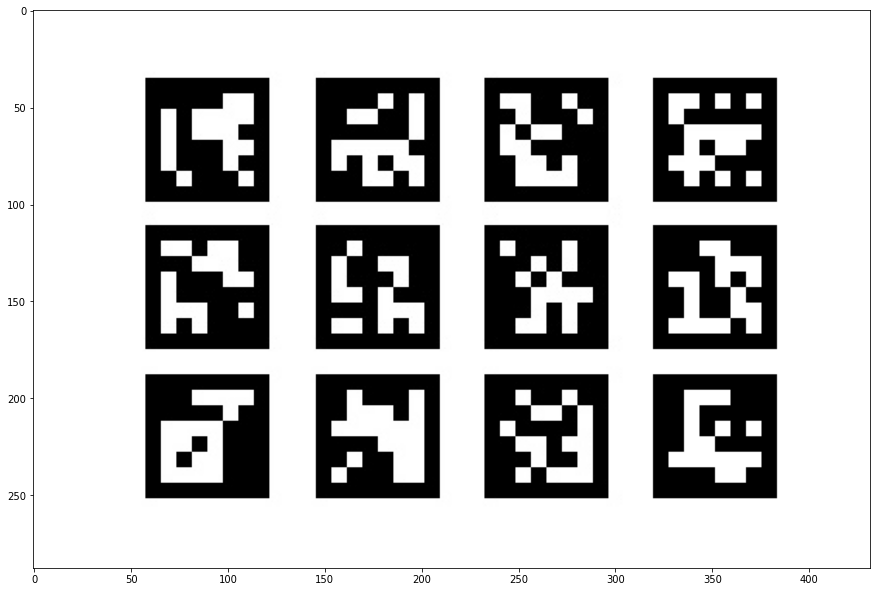

In [50]:
frame = cv2.imread("data/markers.jpg")
plt.figure(figsize = (15,15))
plt.imshow(frame)
plt.show()

gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
aruco_dict = aruco.Dictionary_get(arucodict)
parameters =  aruco.DetectorParameters_create()
corners, ids, rejectedImgPoints = aruco.detectMarkers(gray, aruco_dict, parameters=parameters)
frame_markers = aruco.drawDetectedMarkers(frame.copy(), corners, ids)

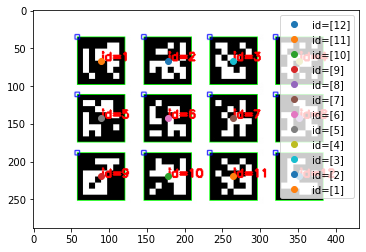

In [13]:
plt.figure()
plt.imshow(frame_markers)
for i in range(len(ids)):
    c = corners[i][0]
    plt.plot([c[:, 0].mean()], [c[:, 1].mean()], "o", label = "id={0}".format(ids[i]))
plt.legend()
plt.show()

In [55]:
import numpy as np
import cv2
from cv2 import aruco
import time

# arucodict = aruco.DICT_6X6_50
aruco_dict = aruco.Dictionary_get(arucodict)
parameters =  aruco.DetectorParameters_create()

# start the capture
cap = cv2.VideoCapture(0)
time.sleep(1.0)
if not cap.isOpened():
    print("Cam open failed")

# main loop
old = time.time()
while(cap.isOpened()):

    # Capture frame-by-frame
    ret, frame = cap.read()

    # Our operations on the frame come here
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    corners, ids, rejectedImgPoints = aruco.detectMarkers(gray, aruco_dict, parameters=parameters)
    frame_markers = aruco.drawDetectedMarkers(frame.copy(), corners, ids)
    if ids is None:
        cv2.putText(frame, '', (0, 10), cv2.FONT_HERSHEY_DUPLEX, 0.5, (0, 255, 0))
    else:
        for i in range(len(ids)):
            c = corners[i][0]
            x = int(c[:, 0].mean())
            y = int(c[:, 1].mean())
            label = "id={0}".format(ids[i])
            cv2.putText(frame, label , (x+10, y+10), cv2.FONT_HERSHEY_DUPLEX, 0.5, (0, 255, 0))
            cv2.circle(frame, (x,y), 1, (0, 255, 0), -1)

    # Trigonometry comes here
    # TODO
    # calculate the distances and the angle
    
    # Communication comes here
    # TODO
    # send the information to the main script
    # https://medium.com/python-pandemonium/python-socket-communication-e10b39225a4c

    # Display the frames per second
    now = time.time()
    fps = 1/(now - old)
    fps_text = "FPS : %0.0f" % fps
    old = now
    cv2.putText(frame, fps_text, (0, 10), cv2.FONT_HERSHEY_DUPLEX, 0.5, (0, 255, 0))
    
    # Display the resulting frame
    cv2.imshow('Preview',frame)
    
    # exit on ESC
    key = cv2.waitKey(1)
    if key == 27:
        break

# When everything done, release the capture
cap.release()
cv2.destroyAllWindows()

In [39]:
if ids:
    print('test')
else:
    print('fail')

fail
